# Trajectory optimization of Bipedal Model

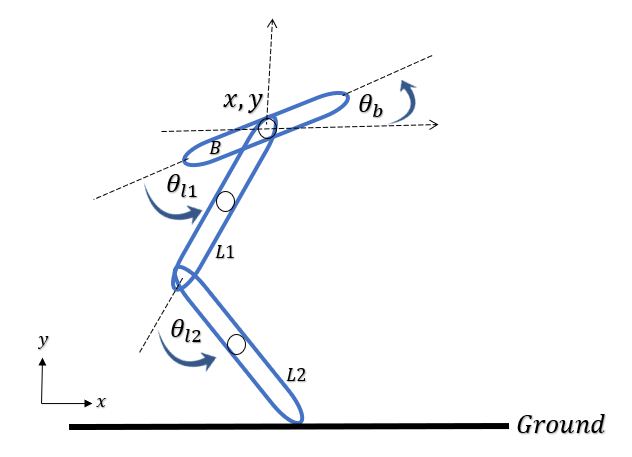

In [1]:
from IPython.display import Image
Image("model.png")

B-The body rotated relative to the inertial space
L1-Link 1 rotates relative to the body 
L2-Link 2 rotates relative to the link 1

Generlized coordinates:
q = 〖[x,y,θ_b,θ_l1,θ_l2]〗^T

In [10]:
#%reset
#DERIVE THE EOMs SYMBOLICALLY ----------------------------------------------------------------------------------------------

#import libraries
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing

#create symbolic variables

#system parameters
g = sym.symbols('g')
X0,Y0 = sym.symbols(['X0','Y0']) #position of first link
mb,ml1,ml2 = sym.symbols(['m_{body}','m_{leg1}','m_{leg2}']) #mass
lb,ll1,ll2 = sym.symbols(['l_{body}','l_{leg1}','l_{leg2}']) #length
Inb,Inl1,Inl2 = sym.symbols(['I_{body}','I_{leg1}','I_{leg2}']) #moment of intertia


# generalized coordinates
x,y,thb,thl1,thl2 = sym.symbols(['x','y','\\theta_{body}','\\theta_{leg1}','\\theta_{leg2}']) #position
dx,dy,dthb,dthl1,dthl2 = sym.symbols(['\dot{x}','\dot{y}','\dot{\\theta}_{body}','\dot{\\theta}_{leg1}','\dot{\\theta}_{leg2}']) 
ddx,ddy,ddthb,ddthl1,ddthl2 = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{\\theta}_{body}','\ddot{\\theta}_{leg1}','\ddot{\\theta}_{leg2}']) 

q = sym.Matrix([[x],[y],[thb],[thl1],[thl2]])
dq = sym.Matrix([[dx],[dy],[dthb],[dthl1],[dthl2]])
ddq = sym.Matrix([[ddx],[ddy],[ddthb],[ddthl1],[ddthl2]])

# forces
# total joint action = actuator + rebound, but that will be dealt with elsewhere
F,tau,GRFx,GRFy = sym.symbols(['F','\\tau','G_x','G_y']) 


# STEP 1: position vectors ri = [x,y,theta] (world frame)
rb = sym.Matrix([[x],
                [y],
                [thb]])

rl1 = sym.Matrix([[x - ll1*sym.sin(thb + thl1)],
                [y - ll1*sym.cos(thb + thl1)],
                [thb + thl1]])

rl2 = sym.Matrix([[x - ll1*sym.sin(thb + thl1)-ll2*sym.sin(thb + thl1+thl2)],
                [y - ll1*sym.cos(thb + thl1)-ll2*sym.cos(thb + thl1+thl2)],
                [thb + thl1+thl2]])

# the Jacobians
Jb = rb.jacobian(q)
Jl1 = rl1.jacobian(q)
Jl2 = rl2.jacobian(q)

# STEP 2: generate expressions for the system space velocities from the jacobians
vb = Jb*dq
vl1 = Jl1*dq
vl2 = Jl2*dq

# STEP 3: generate expressions for the kinetic and potential energy
# mass vectors
Mb = sym.Matrix([[mb,mb,Inb]])
Ml1 = sym.Matrix([[ml1,ml1,Inl1]])
Ml2 = sym.Matrix([[ml2,ml2,Inl2]])

T = 0.5*Mb*sym.matrix_multiply_elementwise(vb,vb) + 0.5*Ml1*sym.matrix_multiply_elementwise(vl1,vl1) + 0.5*Ml2*sym.matrix_multiply_elementwise(vl2,vl2)
T = T[0]
V = mb*g*rb[1] + ml1*g*rl1[1] + ml2*g*rl2[1]


# STEP 4: calculate each term of the Lagrange equation
# term 1
Lg1 = sym.zeros(len(q),1)
for i in range(len(q)):
    dT_ddq = sym.Matrix([sym.diff(T,dq[i])]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = sym.Matrix([T]).jacobian(q).transpose() # partial of T in q

# term 4
Lg4 = sym.Matrix([V]).jacobian(q).transpose() # partial of U in q

# STEP 5: generalized forces

# force vectors for each link
tau_b = sym.Matrix([[0],[0],[-tau]])
tau_l1 = sym.Matrix([[0],[0],[tau]])

F_l1 = sym.Matrix([[-F*sym.sin(thb+thl1)],[F*sym.cos(thb+thl1)],[0]])
F_l2 = sym.Matrix([[F*sym.sin(thb+thl1+thl2)],[-F*sym.cos(thb+thl1+thl2)],[0]])

GRF_l2 = sym.Matrix([[GRFx],[GRFy],[ll2*GRFx*sym.cos(thb+thl1+thl2)+ll2*GRFy*sym.sin(thb+thl1+thl2)]])

Q = sym.zeros(len(q),1)
for j in range(len(q)):
    Q[j] = tau_b.transpose()*Jb[:,j]+(tau_l1+F_l1).transpose()*Jl1[:,j]+(F_l2+GRF_l2).transpose()*Jl2[:,j]

# AND combine!
EOM = Lg1 - Lg3 + Lg4 - Q

EOMs = sym.zeros(len(q),1)
for j in range(len(q)):
    EOMs[j] = EOM[j].simplify()
    
# the simplification step is a little time-consuming so try to avoid re-running this cell if possible.

In [9]:
# Lambdify
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,ml1,ml2,lb,ll1,ll2,Inb,Inl1,Inl2,
            x,y,thb,thl1,thl2,
            dx,dy,dthb,dthl1,dthl2,
            ddx,ddy,ddthb,ddthl1,ddthl2,
            F,tau,GRFx,GRFy]
            
lambEOM_x = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOM_y = sym.lambdify(sym_list,EOMs[1],modules = [func_map])
lambEOM_thb = sym.lambdify(sym_list,EOMs[2],modules = [func_map])
lambEOM_thl = sym.lambdify(sym_list,EOMs[3],modules = [func_map])
lambEOM_r = sym.lambdify(sym_list,EOMs[4],modules = [func_map])

In [8]:
# rerun from here if you don't want to calculate the EOM's again
if 'm' in globals():
    del m # deletes the model
    
m = ConcreteModel()

# SETS-----------------------------------------------------------------------------------------------------------------------

N =100
m.N = RangeSet(N) 

links = [('body',1),('leg',1),('leg',2)]
m.L = Set(dimen=2, initialize = links)

DOFs = ['x','y','theta_b','theta_l1','theta_l2'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

# PARAMETERS-----------------------------------------------------------------------------------------------------------------

m.g = Param(initialize = 9.81)

def get_m(n, lb, ln):
    if lb == 'body':
        return 5.0
    else: return 2.5
m.m = Param(m.L, initialize = get_m) # mass of links

def get_len(n, lb, ln):
    if lb == 'body':
        return 1.0
    else: return 0.5
m.len = Param(m.L, initialize = get_len) # length of links

def calculate_In(m, lb, ln): 
    l = (lb,ln)
    # yes, that does mean you have to rebuild the tuple inside the function. Yes, it is dumb.
    return m.m[l]*m.len[l]**2/12 
m.In = Param(m.L, initialize = calculate_In) # moment of inertia

mbody = sum(m.m[l] for l in links)
BW = mbody*m.g.value

# VARIABLES -----------------------------------------------------------------------------------------------------------------

# system coordinates
m.q = Var(m.N, m.DOF) # position
m.dq = Var(m.N, m.DOF) # velocity
m.ddq = Var(m.N, m.DOF) # acceleration

# bound variables
for n in range(1,N+1):
    for l in links:
        m.q[n,'y'].setlb(0.0)


In [7]:
# TIME AND INTEGRATION

# variable timestep
hm = 0.02 # master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

# Integration constraints 
def BwEuler_p(m,n,dof): # for positions
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

def BwEuler_v(m,n,dof): # for velocities
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)

    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


RuntimeError: Cannot add component 'integrate_p_index' (type <class 'pyomo.core.base.set.SetProduct_OrderedSet'>) to block 'unknown': a component by that name (type <class 'pyomo.core.base.set.SetProduct_OrderedSet'>) is already defined.

In [6]:
# GROUND INTERACTIONS -------------------------------------------------------------------------------------------------------

# paramters
m.mu = Param(initialize = 1) # friction coefficient

# sign set for positive and negative components
signs = ['ps','ng'] 
m.sgn = Set(initialize = signs)

WDOFs = ['X','Y',"THETA"] # absolute coordinates (see what I mean about switching between frames the whole time...?)
m.WDOF = Set(initialize = WDOFs) 

# variables
m.footp = Var(m.N, m.WDOF, bounds = (0.0,None)) # foot position
m.footv = Var(m.N, m.WDOF, m.sgn, bounds = (0.0,None)) # foot velocity

m.friction_cone = Var(m.N, bounds = (0.0,None))

m.GRF = Var(m.N, m.WDOF, m.sgn, bounds = (0.0,None)) # ground reaction forces

ground_constraints = ['contact','friction','slip_ps','slip_ng'] 
m.ground_constraints = Set(initialize = ground_constraints) # set for indexing ground-related penalties
m.ground_penalty = Var(m.N, m.ground_constraints, bounds = (0.0,None))

# constraints: aux variables
def def_footp(m,n,dof):
    if dof == 'Y':
        L = 0.5*m.len[('leg',1)] + m.q[n,'r'] + 0.5*m.len[('leg',2)] # total leg length
        thA = m.q[n,'theta_b'] + m.q[n,'theta_l1']+m.q[n,'theta_l2'] # absolute leg angle
        return m.footp[n,dof] == m.q[n,'y'] - L*cos(thA)
    else:
        return Constraint.Skip
m.def_footp = Constraint(m.N, m.WDOF, rule = def_footp)




# lambdify the foot velocity
footx = sym.Matrix([x - ll1*sym.sin(thb + thl1)-ll2*sym.sin(thb + thl1+thl2)])
footdx = footx.jacobian(q)*dq
footdx = footdx[0].simplify()
lamb_footdx = sym.lambdify(sym_list,footdx,modules = [func_map])

def def_footv(m,n,dof):
    if dof == 'X':
        var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_l1'],m.q[n,'theta_l2'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_l1'],m.dq[n,'theta_l2'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_l1'],m.ddq[n,'theta_l2'],
            0,0,0,0]
        return m.footv[n,dof,'ps']-m.footv[n,dof,'ng'] == lamb_footdx(*var_list)
    else:
        return Constraint.Skip
m.def_footv = Constraint(m.N, m.WDOF, rule = def_footv)

def def_friction_cone(m,n):
    return m.friction_cone[n] == m.mu*m.GRF[n,'Y','ps'] - (m.GRF[n,'X','ps'] + m.GRF[n,'X','ng'])
m.def_friction_cone = Constraint(m.N, rule = def_friction_cone)

# constraints: complementarity

# contact
def ground_contact(m,n):
    if n < N:
        return m.ground_penalty[n,'contact'] == m.footp[n+1,'Y']*m.GRF[n,'Y','ps'] 
    else:
        return Constraint.Skip
m.ground_contact = Constraint(m.N, rule = ground_contact)

# friction
def ground_friction(m,n):
    return m.ground_penalty[n,'friction'] == (m.footv[n,'X','ps']+m.footv[n,'X','ng'])*m.friction_cone[n]
m.ground_friction = Constraint(m.N, rule = ground_friction)

# slipping
def ground_slip_ps(m,n):
    return m.ground_penalty[n,'slip_ps'] == m.footv[n,'X','ps']*m.GRF[n,'X','ps']
m.ground_slip_ps = Constraint(m.N, rule = ground_slip_ps)

def ground_slip_ng(m,n):
    return m.ground_penalty[n,'slip_ng'] == m.footv[n,'X','ng']*m.GRF[n,'X','ng']
m.ground_slip_ng = Constraint(m.N, rule = ground_slip_ng)

# bound contact forces at last node
for dof in WDOFs:
    for sgn in signs:
        m.GRF[N,dof,sgn].value = 0
        m.GRF[N,dof,sgn].fixed = True

ERROR: Rule failed when generating expression for constraint def_footp with
    index (1, 'Y'): KeyError: "Index '(1, 'r')' is not valid for indexed
    component 'q'"
ERROR: Constructing component 'def_footp' from data=None failed: KeyError:
    "Index '(1, 'r')' is not valid for indexed component 'q'"


KeyError: "Index '(1, 'r')' is not valid for indexed component 'q'"